In [1]:
 !pip install tensorflow

In [6]:
import os, json, joblib, random
from pathlib import Path
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, callbacks

In [11]:
# Fix random seed
SEED = 42
random.seed(SEED); np.random.seed(SEED); tf.random.set_seed(SEED)

# Paths
ARTIFACT_DIR = Path("artifacts")
ARTIFACT_DIR.mkdir(exist_ok=True)
SCALER_PATH = ARTIFACT_DIR / "wrapper_minmax_scaler.joblib"
FEATURES_PATH = ARTIFACT_DIR / "features_list.json"
MEDIANS_PATH = ARTIFACT_DIR / "train_medians.joblib"
MODEL_PATH = ARTIFACT_DIR / "best_wrapper_dl.keras"
THRESH_PATH = ARTIFACT_DIR / "best_threshold.json"

# Replace with your own files
TRAIN_CSV = "/content/arp attack detection research dataset 2.csv"
UNSEEN_CSV = "/content/ml_46_features_attack_attack_mili.csv"
Y_COL = "Label"

In [8]:
WRAPPER_FEATURES = [
    "Src_Port","Dst_Port","Protocol","Flow_Duration","Tot_Fwd_Pkts","Tot_Bwd_Pkts",
    "TotLen_Fwd_Pkts","TotLen_Bwd_Pkts","Fwd_Pkt_Len_Max","Fwd_Pkt_Len_Min",
    "Fwd_Pkt_Len_Mean","Fwd_Pkt_Len_Std","Bwd_Pkt_Len_Max","Bwd_Pkt_Len_Min",
    "Bwd_Pkt_Len_Mean","Bwd_Pkt_Len_Std","Flow_Byts/s","Flow_Pkts/s","Flow_IAT_Mean",
    "Flow_IAT_Std","Flow_IAT_Max","Flow_IAT_Min","Fwd_IAT_Tot","Fwd_IAT_Mean","Fwd_IAT_Std",
    "Fwd_IAT_Max","Fwd_IAT_Min","Bwd_IAT_Tot","Bwd_IAT_Mean","Bwd_IAT_Std","Bwd_IAT_Max",
    "Bwd_IAT_Min","FIN_Flag_Cnt","RST_Flag_Cnt","ECE_Flag_Cnt","ACK_Flag_Cnt",
    "Fwd_Seg_Size_Avg","Bwd_Seg_Size_Avg","Fwd_PSH_Flags","Fwd_URG_Flags","SYN_Flag_Cnt",
    "Pkt_Len_Std","Init_Fwd_Win_Byts","Init_Bwd_Win_Byts","Active_Mean","Idle_Std"
]

In [9]:
def load_and_prepare_dataframe(csv_path, features, y_col):
    df = pd.read_csv(csv_path)
    for c in ["Flow_ID","Src_IP","Dst_IP","Timestamp","Cat","Sub_Cat"]:
        if c in df.columns:
            df.drop(columns=c, inplace=True, errors="ignore")
    available = [c for c in features if c in df.columns]
    missing = sorted(set(features) - set(available))
    if missing:
        print("WARNING: missing wrapper columns (skipped):", missing)
    if y_col in df.columns:
        cols = available + [y_col]
    else:
        cols = available
    df = df[cols].drop_duplicates().copy()
    df.replace([np.inf, -np.inf], np.nan, inplace=True)
    return df

def split_and_scale(df, features, y_col, test_size=0.20, val_size=0.20):
    X = df[[c for c in features if c in df.columns]].astype(float)
    y = df[y_col].astype(int)
    X_train_df, X_test_df, y_train, y_test = train_test_split(
        X, y, test_size=test_size, random_state=SEED, stratify=y
    )
    X_train_df, X_val_df, y_train, y_val = train_test_split(
        X_train_df, y_train, test_size=val_size, random_state=SEED, stratify=y_train
    )
    train_medians = X_train_df.median().to_dict()
    joblib.dump(train_medians, MEDIANS_PATH)
    print("Saved train medians")
    X_train_df = X_train_df.fillna(pd.Series(train_medians))
    X_val_df   = X_val_df.fillna(pd.Series(train_medians))
    X_test_df  = X_test_df.fillna(pd.Series(train_medians))
    scaler = MinMaxScaler()
    X_train_s = scaler.fit_transform(X_train_df)
    X_val_s   = scaler.transform(X_val_df)
    X_test_s  = scaler.transform(X_test_df)
    joblib.dump(scaler, SCALER_PATH)
    with open(FEATURES_PATH, "w") as f:
        json.dump(X_train_df.columns.tolist(), f)
    return X_train_s, X_val_s, X_test_s, y_train.values, y_val.values, y_test.values

def compute_class_weights(y_train):
    classes = np.unique(y_train)
    cw = compute_class_weight(class_weight="balanced", classes=classes, y=y_train)
    return {int(k): float(v) for k,v in zip(classes, cw)}

def make_model(input_dim, dropout=0.2, lr=1e-3):
    model = keras.Sequential([
        layers.Input(shape=(input_dim,)),
        layers.Dense(128, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(dropout),
        layers.Dense(64, activation="relu"),
        layers.BatchNormalization(),
        layers.Dropout(dropout/2),
        layers.Dense(32, activation="relu"),
        layers.Dense(1, activation="sigmoid"),
    ])
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate=lr),
        loss="binary_crossentropy",
        metrics=["accuracy", keras.metrics.Precision(), keras.metrics.Recall(), keras.metrics.AUC()]
    )
    return model

def find_best_threshold(y_true, y_proba):
    thresholds = np.linspace(0,1,101)
    best_t, best_f1 = 0.5, -1
    from sklearn.metrics import f1_score
    for t in thresholds:
        preds = (y_proba >= t).astype(int)
        score = f1_score(y_true, preds)
        if score > best_f1:
            best_f1, best_t = score, t
    return best_t


In [12]:
df = load_and_prepare_dataframe(TRAIN_CSV, WRAPPER_FEATURES, Y_COL)
X_train_s, X_val_s, X_test_s, y_train, y_val, y_test = split_and_scale(df, WRAPPER_FEATURES, Y_COL)

CLASS_WEIGHT = compute_class_weights(y_train)
model = make_model(X_train_s.shape[1])
model.summary()

ES = callbacks.EarlyStopping(monitor="val_auc", mode="max", patience=8, restore_best_weights=True)
CKPT = callbacks.ModelCheckpoint(str(MODEL_PATH), monitor="val_auc", mode="max", save_best_only=True)

history = model.fit(
    X_train_s, y_train,
    validation_data=(X_val_s, y_val),
    epochs=100,
    batch_size=1024,
    class_weight=CLASS_WEIGHT,
    callbacks=[ES, CKPT],
    verbose=1
)


Saved train medians


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         6,016 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 17,153 (67.00 KB)

 Trainable params: 16,769 (65.50 KB)

 Non-trainable params: 384 (1.50 KB)

Epoch 1/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 12s 253ms/step - accuracy: 0.6632 - auc: 0.8387 - loss: 0.5590 - precision: 0.5300 - recall: 0.9431 - val_accuracy: 0.7721 - val_auc: 0.9456 - val_loss: 0.5375 - val_precision: 0.9410 - val_recall: 0.3710
Epoch 2/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9461 - auc: 0.9782 - loss: 0.1704 - precision: 0.8866 - recall: 0.9722 - val_accuracy: 0.7979 - val_auc: 0.9708 - val_loss: 0.4512 - val_precision: 0.9423 - val_recall: 0.4492
Epoch 3/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9537 - auc: 0.9816 - loss: 0.1397 - precision: 0.8993 - recall: 0.9791 - val_accuracy: 0.8101 - val_auc: 0.9772 - val_loss: 0.3874 - val_precision: 0.9340 - val_recall: 0.4911
Epoch 4/100
27/27 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - accuracy: 0.9588 - auc: 0.9827 - loss: 0.1285 - precision: 0.9079 - recall: 0.9834 - val_accuracy: 0.8498 - val_auc: 0.9793 - val_loss: 0.3328 - val_precision: 0.9266 - val_recall: 0.6193
Epoch 5/100
27/27 ━━━━━━━━━━━━━━━

In [13]:
best = keras.models.load_model(str(MODEL_PATH))
val_proba = best.predict(X_val_s).ravel()
best_t = find_best_threshold(y_val, val_proba)
print("Best threshold:", best_t)

test_proba = best.predict(X_test_s).ravel()
test_pred = (test_proba >= best_t).astype(int)

print("Confusion Matrix:\n", confusion_matrix(y_test, test_pred))
print(classification_report(y_test, test_pred, digits=4))
print("ROC AUC:", roc_auc_score(y_test, test_proba))

with open(THRESH_PATH, "w") as f:
    json.dump({"threshold": float(best_t)}, f)


212/212 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step
Best threshold: 0.43
265/265 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
Confusion Matrix:
 [[5403   98]
 [   5 2950]]
              precision    recall  f1-score   support

           0     0.9991    0.9822    0.9906      5501
           1     0.9678    0.9983    0.9828      2955

    accuracy                         0.9878      8456
   macro avg     0.9835    0.9902    0.9867      8456
weighted avg     0.9882    0.9878    0.9879      8456

ROC AUC: 0.9976447906256699


In [16]:
# Load artifacts
scaler = joblib.load(SCALER_PATH)
train_medians = joblib.load(MEDIANS_PATH)
with open(FEATURES_PATH) as f:
    feature_list = json.load(f)
with open(THRESH_PATH) as f:
    best_t = json.load(f)["threshold"]
model = keras.models.load_model(str(MODEL_PATH))

# Load unseen
df_unseen = pd.read_csv(UNSEEN_CSV)
df_unseen.replace([np.inf, -np.inf], np.nan, inplace=True)
for f in feature_list:
    if f not in df_unseen.columns:
        df_unseen[f] = train_medians.get(f, 0)
df_unseen = df_unseen[feature_list].fillna(pd.Series(train_medians))

X_unseen_s = scaler.transform(df_unseen.astype(float))
proba = model.predict(X_unseen_s).ravel()
pred = (proba >= best_t).astype(int)

df_unseen["pred_label"] = pred
df_unseen["proba_attack"] = proba
df_unseen.to_csv("unseen_predictions.csv", index=False)
print("Saved unseen predictions -> unseen_predictions.csv")


6/6 ━━━━━━━━━━━━━━━━━━━━ 1s 92ms/step
Saved unseen predictions -> unseen_predictions.csv


method 2

In [18]:
!pip install pandas numpy scikit-learn xgboost joblib --quiet


In [19]:
import os, random
import numpy as np
import pandas as pd
import joblib

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

SEED = 42
random.seed(SEED); np.random.seed(SEED)


In [20]:
# CHANGE THIS TO YOUR DATASET PATH
CSV_PATH = "/content/arp attack detection research dataset 2.csv"

df = pd.read_csv(CSV_PATH)

# Define target column
y_col = "Label"

# Drop unnecessary columns if present
DROP_COLS = ["Flow_ID","Src_IP","Dst_IP","Timestamp","Cat","Sub_Cat"]
to_drop_now = [c for c in DROP_COLS if c in df.columns]
df.drop(columns=to_drop_now, inplace=True, errors="ignore")

# Feature list
WRAPPER_FEATURES = [
    "Src_Port","Dst_Port","Protocol","Flow_Duration","Tot_Fwd_Pkts","Tot_Bwd_Pkts",
    "TotLen_Fwd_Pkts","TotLen_Bwd_Pkts","Fwd_Pkt_Len_Max","Fwd_Pkt_Len_Min",
    "Fwd_Pkt_Len_Mean","Fwd_Pkt_Len_Std","Bwd_Pkt_Len_Max","Bwd_Pkt_Len_Min",
    "Bwd_Pkt_Len_Mean","Bwd_Pkt_Len_Std","Flow_Byts/s","Flow_Pkts/s","Flow_IAT_Mean",
    "Flow_IAT_Std","Flow_IAT_Max","Flow_IAT_Min","Fwd_IAT_Tot","Fwd_IAT_Mean","Fwd_IAT_Std",
    "Fwd_IAT_Max","Fwd_IAT_Min","Bwd_IAT_Tot","Bwd_IAT_Mean","Bwd_IAT_Std","Bwd_IAT_Max",
    "Bwd_IAT_Min","FIN_Flag_Cnt","RST_Flag_Cnt","ECE_Flag_Cnt","ACK_Flag_Cnt",
    "Fwd_Seg_Size_Avg","Bwd_Seg_Size_Avg","Fwd_PSH_Flags","Fwd_URG_Flags","SYN_Flag_Cnt",
    "Pkt_Len_Std","Init_Fwd_Win_Byts","Init_Bwd_Win_Byts","Active_Mean","Idle_Std"
]

available = [c for c in WRAPPER_FEATURES if c in df.columns]
df = df[available + [y_col]].copy()

# Handle NaN/inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(), inplace=True)


In [21]:
X = df[available].astype(float)
y = df[y_col].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

# Save scaler for unseen data
joblib.dump(scaler, "wrapper_minmax_scaler.joblib")


['wrapper_minmax_scaler.joblib']

In [22]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1
)

rf.fit(X_train_s, y_train)

pred_rf = rf.predict(X_test_s)
proba_rf = rf.predict_proba(X_test_s)[:,1]

print("RandomForest Results")
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf, digits=4))
print("ROC AUC:", roc_auc_score(y_test, proba_rf))

# Save model
joblib.dump(rf, "rf_model.pkl")


RandomForest Results
[[7949   66]
 [   8 7067]]
              precision    recall  f1-score   support

           0     0.9990    0.9918    0.9954      8015
           1     0.9907    0.9989    0.9948      7075

    accuracy                         0.9951     15090
   macro avg     0.9949    0.9953    0.9951     15090
weighted avg     0.9951    0.9951    0.9951     15090

ROC AUC: 0.9997312812328474


['rf_model.pkl']

In [23]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=SEED,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train_s, y_train)

pred_xgb = xgb_model.predict(X_test_s)
proba_xgb = xgb_model.predict_proba(X_test_s)[:,1]

print("XGBoost Results")
print(confusion_matrix(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb, digits=4))
print("ROC AUC:", roc_auc_score(y_test, proba_xgb))

# Save model
joblib.dump(xgb_model, "xgb_model.pkl")


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:02:45] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results
[[7969   46]
 [   8 7067]]
              precision    recall  f1-score   support

           0     0.9990    0.9943    0.9966      8015
           1     0.9935    0.9989    0.9962      7075

    accuracy                         0.9964     15090
   macro avg     0.9963    0.9966    0.9964     15090
weighted avg     0.9964    0.9964    0.9964     15090

ROC AUC: 0.9998359260132834


['xgb_model.pkl']

In [37]:
# CHANGE PATH
UNSEEN_CSV_PATH = "/content/ml_46_features_attack_attack_mili.csv"

df_unseen = pd.read_csv(UNSEEN_CSV_PATH)

# Load scaler
scaler = joblib.load("wrapper_minmax_scaler.joblib")

# Match training features
df_unseen = df_unseen[[c for c in df_unseen.columns if c in available]]

# Add missing features as 0
for f in available:
    if f not in df_unseen.columns:
        df_unseen[f] = 0

df_unseen = df_unseen[available]
df_unseen.replace([np.inf, -np.inf], np.nan, inplace=True)
df_unseen.fillna(df_unseen.median(), inplace=True)

# Scale
X_unseen_s = scaler.transform(df_unseen.astype(float))

# ---- Predict with RF ----
rf = joblib.load("rf_model.pkl")
pred_unseen_rf = rf.predict(X_unseen_s)
proba_unseen_rf = rf.predict_proba(X_unseen_s)[:,1]

# ---- Predict with XGB ----
xgb_model = joblib.load("xgb_model.pkl")
pred_unseen_xgb = xgb_model.predict(X_unseen_s)
proba_unseen_xgb = xgb_model.predict_proba(X_unseen_s)[:,1]

print("✅ RandomForest Unseen Predictions:", np.unique(pred_unseen_rf, return_counts=True))
print("✅ XGBoost Unseen Predictions:", np.unique(pred_unseen_xgb, return_counts=True))


✅ RandomForest Unseen Predictions: (array([0, 1]), array([ 68, 103]))
✅ XGBoost Unseen Predictions: (array([0, 1]), array([ 67, 104]))


method 3

In [26]:
import os, random, joblib, json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.utils.class_weight import compute_class_weight
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb

SEED = 42
random.seed(SEED)
np.random.seed(SEED)

# Paths
ARTIFACT_DIR = "artifacts"
os.makedirs(ARTIFACT_DIR, exist_ok=True)

TRAIN_CSV = "/content/arp attack detection research dataset 2.csv"
UNSEEN_CSV = "/content/ml_46_features_attack_attack_mili.csv"
Y_COL = "Label"


In [27]:
df = pd.read_csv(TRAIN_CSV)

# Drop unnecessary columns
DROP_COLS = ["Flow_ID","Src_IP","Dst_IP","Timestamp","Cat","Sub_Cat"]
df.drop(columns=[c for c in DROP_COLS if c in df.columns], inplace=True, errors="ignore")

# Wrapper features
WRAPPER_FEATURES = [
    "Src_Port","Dst_Port","Protocol","Flow_Duration","Tot_Fwd_Pkts","Tot_Bwd_Pkts",
    "TotLen_Fwd_Pkts","TotLen_Bwd_Pkts","Fwd_Pkt_Len_Max","Fwd_Pkt_Len_Min",
    "Fwd_Pkt_Len_Mean","Fwd_Pkt_Len_Std","Bwd_Pkt_Len_Max","Bwd_Pkt_Len_Min",
    "Bwd_Pkt_Len_Mean","Bwd_Pkt_Len_Std","Flow_Byts/s","Flow_Pkts/s","Flow_IAT_Mean",
    "Flow_IAT_Std","Flow_IAT_Max","Flow_IAT_Min","Fwd_IAT_Tot","Fwd_IAT_Mean","Fwd_IAT_Std",
    "Fwd_IAT_Max","Fwd_IAT_Min","Bwd_IAT_Tot","Bwd_IAT_Mean","Bwd_IAT_Std","Bwd_IAT_Max",
    "Bwd_IAT_Min","FIN_Flag_Cnt","RST_Flag_Cnt","ECE_Flag_Cnt","ACK_Flag_Cnt",
    "Fwd_Seg_Size_Avg","Bwd_Seg_Size_Avg","Fwd_PSH_Flags","Fwd_URG_Flags","SYN_Flag_Cnt",
    "Pkt_Len_Std","Init_Fwd_Win_Byts","Init_Bwd_Win_Byts","Active_Mean","Idle_Std"
]

available = [c for c in WRAPPER_FEATURES if c in df.columns]
df = df[available + [Y_COL]].copy()

# Handle NaN / inf
df.replace([np.inf, -np.inf], np.nan, inplace=True)
df.fillna(df.median(), inplace=True)


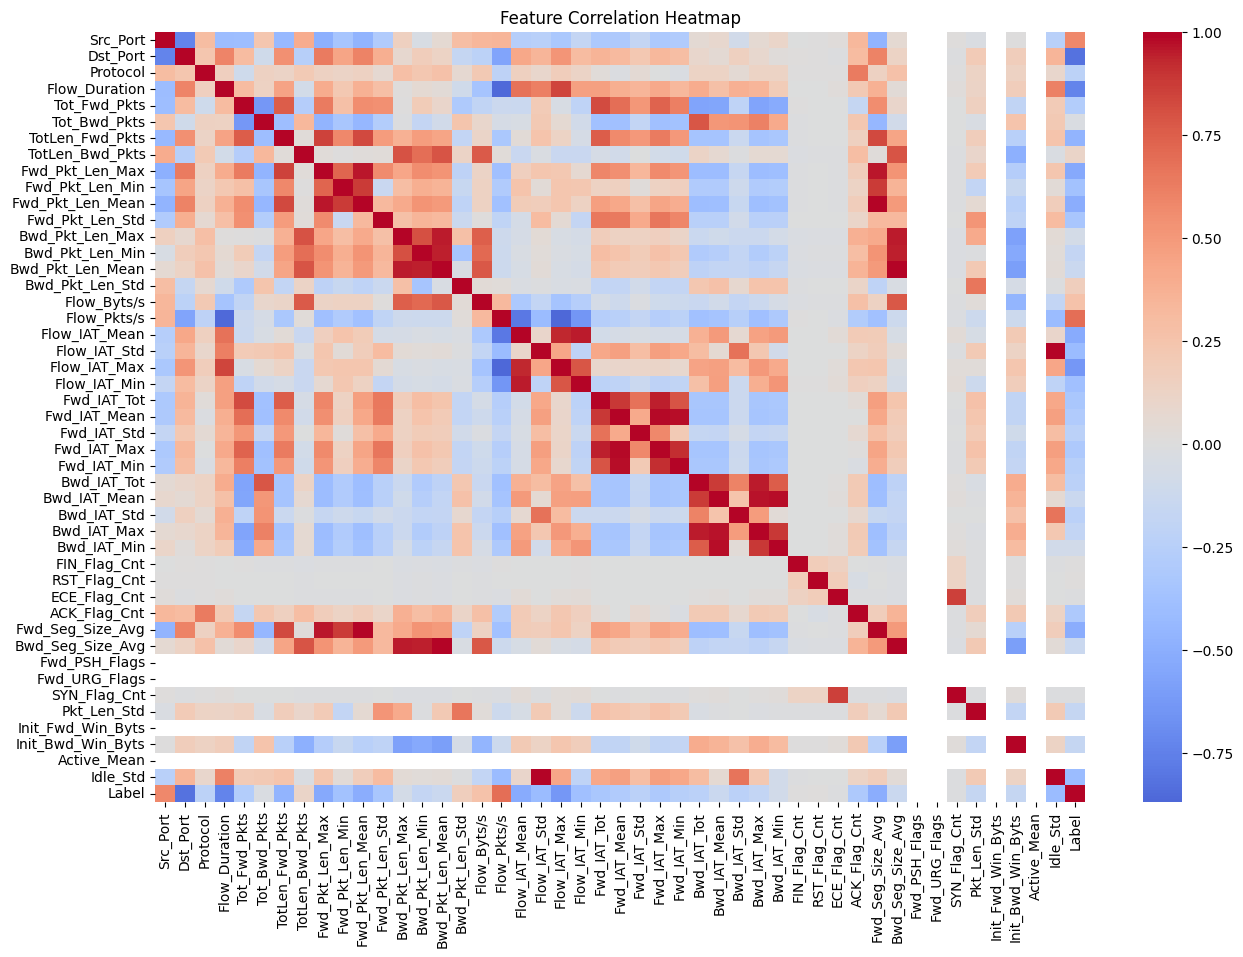

Top features correlated with Label:
 Flow_Pkts/s         0.690956
Src_Port            0.579852
Flow_Byts/s         0.259239
Bwd_Pkt_Len_Std     0.166865
TotLen_Bwd_Pkts     0.114680
RST_Flag_Cnt        0.008559
FIN_Flag_Cnt        0.006497
SYN_Flag_Cnt       -0.008800
ECE_Flag_Cnt       -0.009890
Tot_Bwd_Pkts       -0.023800
Bwd_Pkt_Len_Max    -0.078416
Bwd_IAT_Min        -0.087993
Bwd_Seg_Size_Avg   -0.131301
Bwd_Pkt_Len_Mean   -0.131301
Bwd_IAT_Mean       -0.136438
Name: Label, dtype: float64


In [28]:
corr_matrix = df[available + [Y_COL]].corr()

plt.figure(figsize=(15,10))
sns.heatmap(corr_matrix, cmap="coolwarm", center=0, annot=False)
plt.title("Feature Correlation Heatmap")
plt.show()

# Top correlations with target
corr_target = corr_matrix[Y_COL].drop(Y_COL).sort_values(ascending=False)
print("Top features correlated with Label:\n", corr_target.head(15))


In [29]:
threshold = 0.9
corr_pairs = set()
for i in range(len(corr_matrix.columns)):
    for j in range(i):
        if abs(corr_matrix.iloc[i,j]) > threshold:
            colname = corr_matrix.columns[i]
            corr_pairs.add(colname)

print("Dropping highly correlated features:", corr_pairs)
df_reduced = df.drop(columns=list(corr_pairs), errors="ignore")
available_reduced = [c for c in available if c in df_reduced.columns]


Dropping highly correlated features: {'Bwd_IAT_Max', 'Fwd_IAT_Max', 'Fwd_Pkt_Len_Mean', 'Fwd_IAT_Min', 'Flow_IAT_Max', 'Bwd_IAT_Min', 'Bwd_Seg_Size_Avg', 'Fwd_Seg_Size_Avg', 'Idle_Std', 'Bwd_Pkt_Len_Mean', 'Flow_IAT_Min'}


In [31]:
X_fs = df_reduced[available_reduced].astype(float)
y_fs = df_reduced[Y_COL].astype(int)

# Mutual Information
mi_selector = SelectKBest(mutual_info_classif, k=20)
mi_selector.fit(X_fs, y_fs)
mi_features = X_fs.columns[mi_selector.get_support()].tolist()

print("Top features by Mutual Information:\n", mi_features)

# Use features selected by Mutual Information
final_features = mi_features
print("\nFinal selected features:", final_features)

Top features by Mutual Information:
 ['Src_Port', 'Dst_Port', 'Flow_Duration', 'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Fwd_IAT_Tot', 'Fwd_IAT_Mean', 'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Pkt_Len_Std', 'Init_Bwd_Win_Byts']

Final selected features: ['Src_Port', 'Dst_Port', 'Flow_Duration', 'TotLen_Fwd_Pkts', 'TotLen_Bwd_Pkts', 'Fwd_Pkt_Len_Max', 'Fwd_Pkt_Len_Min', 'Fwd_Pkt_Len_Std', 'Bwd_Pkt_Len_Max', 'Bwd_Pkt_Len_Min', 'Flow_Byts/s', 'Flow_Pkts/s', 'Flow_IAT_Mean', 'Flow_IAT_Std', 'Fwd_IAT_Tot', 'Fwd_IAT_Mean', 'Bwd_IAT_Tot', 'Bwd_IAT_Mean', 'Pkt_Len_Std', 'Init_Bwd_Win_Byts']


In [32]:
X = df_reduced[final_features].astype(float)
y = df_reduced[Y_COL].astype(int)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=SEED
)

scaler = MinMaxScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s  = scaler.transform(X_test)

joblib.dump(scaler, os.path.join(ARTIFACT_DIR,"scaler_selected.joblib"))


['artifacts/scaler_selected.joblib']

In [33]:
rf = RandomForestClassifier(
    n_estimators=300,
    class_weight="balanced",
    random_state=SEED,
    n_jobs=-1
)

rf.fit(X_train_s, y_train)

pred_rf = rf.predict(X_test_s)
proba_rf = rf.predict_proba(X_test_s)[:,1]

print("RandomForest Results")
print(confusion_matrix(y_test, pred_rf))
print(classification_report(y_test, pred_rf, digits=4))
print("ROC AUC:", roc_auc_score(y_test, proba_rf))

joblib.dump(rf, os.path.join(ARTIFACT_DIR,"rf_model_selected.pkl"))


RandomForest Results
[[7956   59]
 [   7 7068]]
              precision    recall  f1-score   support

           0     0.9991    0.9926    0.9959      8015
           1     0.9917    0.9990    0.9954      7075

    accuracy                         0.9956     15090
   macro avg     0.9954    0.9958    0.9956     15090
weighted avg     0.9957    0.9956    0.9956     15090

ROC AUC: 0.999836296343649


['artifacts/rf_model_selected.pkl']

In [34]:
xgb_model = xgb.XGBClassifier(
    n_estimators=300,
    max_depth=8,
    learning_rate=0.1,
    scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
    random_state=SEED,
    n_jobs=-1,
    use_label_encoder=False,
    eval_metric="logloss"
)

xgb_model.fit(X_train_s, y_train)

pred_xgb = xgb_model.predict(X_test_s)
proba_xgb = xgb_model.predict_proba(X_test_s)[:,1]

print("XGBoost Results")
print(confusion_matrix(y_test, pred_xgb))
print(classification_report(y_test, pred_xgb, digits=4))
print("ROC AUC:", roc_auc_score(y_test, proba_xgb))

joblib.dump(xgb_model, os.path.join(ARTIFACT_DIR,"xgb_model_selected.pkl"))


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [20:19:57] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost Results
[[7970   45]
 [   8 7067]]
              precision    recall  f1-score   support

           0     0.9990    0.9944    0.9967      8015
           1     0.9937    0.9989    0.9963      7075

    accuracy                         0.9965     15090
   macro avg     0.9963    0.9966    0.9965     15090
weighted avg     0.9965    0.9965    0.9965     15090

ROC AUC: 0.9998352118047212


['artifacts/xgb_model_selected.pkl']

In [35]:
df_unseen = pd.read_csv(UNSEEN_CSV)

# Load scaler
scaler = joblib.load(os.path.join(ARTIFACT_DIR,"scaler_selected.joblib"))

# Match training features
for f in final_features:
    if f not in df_unseen.columns:
        df_unseen[f] = 0

df_unseen = df_unseen[final_features]
df_unseen.replace([np.inf, -np.inf], np.nan, inplace=True)
df_unseen.fillna(df_unseen.median(), inplace=True)

X_unseen_s = scaler.transform(df_unseen.astype(float))

# RandomForest Prediction
rf = joblib.load(os.path.join(ARTIFACT_DIR,"rf_model_selected.pkl"))
pred_unseen_rf = rf.predict(X_unseen_s)
proba_unseen_rf = rf.predict_proba(X_unseen_s)[:,1]

# XGBoost Prediction
xgb_model = joblib.load(os.path.join(ARTIFACT_DIR,"xgb_model_selected.pkl"))
pred_unseen_xgb = xgb_model.predict(X_unseen_s)
proba_unseen_xgb = xgb_model.predict_proba(X_unseen_s)[:,1]

# Save predictions
df_unseen["pred_label_rf"] = pred_unseen_rf
df_unseen["proba_rf"] = proba_unseen_rf
df_unseen["pred_label_xgb"] = pred_unseen_xgb
df_unseen["proba_xgb"] = proba_unseen_xgb

df_unseen.to_csv("unseen_predictions_selected.csv", index=False)
print("✅ Predictions saved to unseen_predictions_selected.csv")


✅ Predictions saved to unseen_predictions_selected.csv


In [36]:
print("✅ RandomForest Unseen Predictions:", np.unique(pred_unseen_rf, return_counts=True))
print("✅ XGBoost Unseen Predictions:", np.unique(pred_unseen_xgb, return_counts=True))

✅ RandomForest Unseen Predictions: (array([0, 1]), array([ 68, 103]))
✅ XGBoost Unseen Predictions: (array([0, 1]), array([ 67, 104]))
